<img style="float: right;" src="figures/pylady_geek.png">

## How can I perform a comparison between ML pipelines in BCI?
#### [Marie-Constance Corsi](https://marieconstance-corsi.netlify.app/), Aramis lab, Paris

## Overview

* Generalities
* Defining a pipeline
* Comparison with the state-of-the art
* Statistical analysis
* Plotting the results
* Concluding remarks / FAQ

<img style="float: right;" src="figures/python.png" alt="drawing" width="120">

### Generalities

This demo relies on several open-source Python packages:

* [MOABB](http://moabb.neurotechx.com/docs/) & [[Jayaram & Barachant, 2018]](https://iopscience.iop.org/article/10.1088/1741-2552/aadea0)
* [Pyriemann](https://pyriemann.readthedocs.io/en/latest/#) & [[Barachant et al, 2022]](https://doi.org/10.5281/zenodo.7547583)
* [MNE-Python](https://mne.tools/stable/index.html) & [[Gramfort et al, 2014]](https://pubmed.ncbi.nlm.nih.gov/24161808/)
* [scikit-learn](https://scikit-learn.org/stable/)
* [Matplotlib](https://matplotlib.org/stable/index.html)
* [Seaborn](https://seaborn.pydata.org)
* [Pyvis](https://pyvis.readthedocs.io/en/latest/tutorial.html)


The packages used for running this notebook are indicated in the requirements.txt file and could be installed with ``` pip install -r requirements.txt ```

#### Dataset
Use of an open dataset from [[Schalk et al, 2004]](https://ieeexplore.ieee.org/document/1300799)

#### /!\ Warning /!\
Here, we will compare the performance obtained with the [FUCONE](https://github.com/mccorsi/FUCONE) approach presented during the talk and the state-of-the-art methods. Most of the materials can be found [here](https://pyriemann.readthedocs.io/en/latest/auto_examples/motor-imagery/plot_ensemble_coherence.html).

The choice and the parametrization of the methods may differ depending on your dataset and your hypothesis !

### Step 0 - We import the packages necessary to perform our analysis

In [18]:
import matplotlib.pyplot as plt

import moabb.analysis.plotting as moabb_plt
from moabb.analysis.meta_analysis import (  # noqa: E501
    compute_dataset_statistics,
    find_significant_differences,
)

from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci

import numpy as np
import pandas as pd
import seaborn as sns

from pyriemann.classification import FgMDM
from pyriemann.estimation import Covariances, Coherences
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from helpers.coherence_helpers import (
    NearestSPD,
    get_results,
)

### Step 1 - We define a class to extract connectivity-based features

In [19]:
class Connectivities(TransformerMixin, BaseEstimator):
    """Getting connectivity features from epoch"""

    def __init__(self, method="ordinary", fmin=8, fmax=35, fs=None):
        self.method = method
        self.fmin = fmin
        self.fmax = fmax
        self.fs = fs

    def fit(self, X, y=None):
        self._coh = Coherences(
            coh=self.method,
            fmin=self.fmin,
            fmax=self.fmax,
            fs=self.fs,
        )
        return self

    def transform(self, X):
        X_coh = self._coh.fit_transform(X)
        X_con = np.mean(X_coh, axis=-1, keepdims=False)
        return X_con

### Step 2 - We load the data we need from the eegbci dataset

In [3]:
# avoid classification of evoked responses by using epochs that start 1 second after cue onset.
dataset = "eegbci"
tmin, tmax = 1.0, 2.0
event_id = dict(hands=2, feet=3)
subject = 7
runs = [4, 8]  # motor imagery: left vs right hand

raw_files = [
    read_raw_edf(f, preload=True) for f in eegbci.load_data(subject, runs)
]
raw = concatenate_raws(raw_files)

picks = pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads"
)
# subsample elecs
picks = picks[::2]

# Apply band-pass filter
raw.filter(7.0, 35.0, method="iir", picks=picks)

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# Read epochs (train will be done only between 1 and 2s)
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)
labels = epochs.events[:, -1] - 2
fs = epochs.info["sfreq"]
X = 1e6 * epochs.get_data()


Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., Cz.., C2.., C4.., C6.., Cp5., Cp3., Cp1., Cpz., Cp2., Cp4., Cp6., Fp1., Fpz., Fp2., Af7., Af3., Afz., Af4., Af8., F7.., F5.., F3.., F1.., Fz.., F2.., F4.., F6.., F8.., Ft7., Ft8., T7.., T8.., T9.., T10., Tp7., Tp8., P7.., P5.., P3.., P1.., Pz.., P2.., P4.., P6.., P8.., Po7., Po3., Poz., Po4., Po8., O1.., Oz.., O2.., Iz..
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/marieconstance.corsi/Documents/GitHub/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R08.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channel

In [60]:
# let's explore/check the data information!

#epochs.info.keys()
#epochs.info["ch_names"]
# event_id
#np.shape(events)
#events

#np.shape(X)


In [4]:
#plot epochs - timeseries
#epochs['hands'].plot(events=events, event_id=event_id)

In [5]:
#plot epochs - psd
# epochs['hands'].plot_psd(picks='eeg')
# epochs['feet'].plot_psd(picks='eeg') # for C3: picks=['C3..']

In [7]:
# plot overview over the trials
# epochs['hands'].plot_image(picks=['C3..'])
# epochs['feet'].plot_image(picks=['C3..'])

### Step 3 - We define our pipelines

In [8]:
# ppl_baseline corresponds to the state-of-the-art methods to which we will compare our pipeline
# ppl_fc corresponds to the pipeline relying on specific functional connectivity metrics
# ppl_ens corresponds to the FUCONE approach, aka, applying an ensemble method
ppl_baseline, ppl_fc, ppl_ens = {}, {}, {}

In [9]:
# Baseline - CSP+optSVM
param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
step_csp = [
    ("cov", Covariances(estimator="lwf")),
    ("csp", CSP(nfilter=6)),
    ("optsvm", GridSearchCV(SVC(), param_svm, cv=3)),
]
ppl_baseline["CSP+optSVM"] = Pipeline(steps=step_csp)

# Baseline - FgMDM
step_mdm = [
    ("cov", Covariances(estimator="lwf")),
    ("fgmdm", FgMDM(metric="riemann", tsupdate=False)),
]
ppl_baseline["FgMDM"] = Pipeline(steps=step_mdm)

In [10]:
# list of features used: covariance matrices, lagged coherence, instantaneous coherence
spectral_met = ["cov", "lagged", "instantaneous"]
fmin, fmax = 8, 35
param_lr = {
    "penalty": "elasticnet",
    "l1_ratio": 0.15,
    "intercept_scaling": 1000.0,
    "solver": "saga",
}
param_ft = {"fmin": fmin, "fmax": fmax, "fs": fs}

# We apply a logistic regression in tangent space
step_fc = [
    ("spd", NearestSPD()),
    ("tg", TangentSpace(metric="riemann")),
    ("LogistReg", LogisticRegression(**param_lr)), 
]
for sm in spectral_met:
    pname = sm + "+elasticnet"
    if sm == "cov":
        ppl_fc[pname] = Pipeline(
            steps=[("cov", Covariances(estimator="lwf"))] + step_fc
        )
    else:
        ft = Connectivities(**param_ft, method=sm)
        ppl_fc[pname] = Pipeline(steps=[("ft", ft)] + step_fc)

In [11]:
# Here, the ensemble classifier stacks a logistic regression on top of the three functional connectivity pipelines for a global prediction
fc_estim = [(n, ppl_fc[n]) for n in ppl_fc]
cvkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(**param_lr)
ppl_ens["ensemble"] = StackingClassifier(
    estimators=fc_estim,
    cv=cvkf,
    n_jobs=1,
    final_estimator=lr,
    stack_method="predict_proba",
)


### Step 4 - We perform the evaluation

In [12]:
dataset_res = list()
all_ppl = {**ppl_baseline, **ppl_ens}

# Compute results
results = get_results(X, labels, all_ppl)
results = pd.DataFrame(results)

# Add a subject & dataset columns for the upcoming steps
results.insert(0, 'subject', subject)
results.insert(0, 'dataset', dataset)

/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/opt/anaconda3/envs/tuto_meeg/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: T

### Step 5 - We analyse and we plot the results 

In [13]:
# Just to have an idea about the content of the dataframe
#results

In [14]:
# simply for the record, some useful functions to use for a thorough statistical analysis - not relevant here given the low number of samplings to be compared
stats = compute_dataset_statistics(results)
P, T = find_significant_differences(stats) # comparison of pipelines, 2 by 2
# moabb_plt.summary_plot(P, T, p_threshold=0.05, simplify=True)

Text(0.5, 1.0, 'Comparison between pipelines in subject 7')

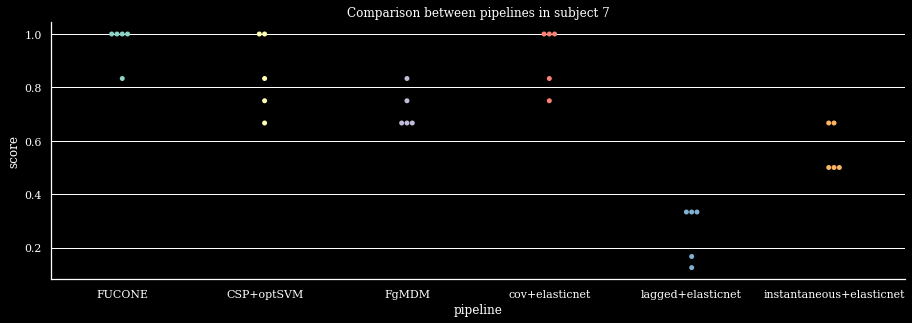

In [16]:
plt.style.use("dark_background")

list_fc_ens = ["ensemble", "CSP+optSVM", "FgMDM"] + \
    [sm + "+elasticnet" for sm in spectral_met]

list_fc_ens_disp= ["FUCONE", "CSP+optSVM", "FgMDM"] + \
    [sm + "+elasticnet" for sm in spectral_met]

g = sns.catplot(
    data=results,
    x="pipeline",
    y="score",
    kind="swarm",
    order=list_fc_ens,
    height=4.2,
    aspect=3,
)
plt.xticks(range(len(list_fc_ens_disp)),list_fc_ens_disp)
plt.title('Comparison between pipelines in subject ' + str(subject))
plt.show()